In [1]:
# Import modules

from music21 import *
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import itertools as iter

from dimod import BinaryQuadraticModel
import dimod.generators
from dwave.samplers import SteepestDescentSolver
from dwave.system import DWaveSampler, EmbeddingComposite

from calculators import *
from boundaryDetection import *
from graphUtilities import *
from graphPlotters import plotBoundaryStrength

In [2]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl")
excerpt = score
identifier = "haydn_opus1no1_movement1"

#excerpt.show()

In [16]:
# Boundary detection

phraseLists = []
threshold = 0.3
weightings = (0.3, 0.6)

for part in excerpt.parts:
        print(f"Creating phrases for {part.id} part...")
        #plotBoundaryStrength(part, threshold, weightings)
        phrases = extractPhrases(part, threshold, weightings, f"{part.id}")
        print(f"{len(phrases)} phrases created!")
        phraseLists.append(phrases)

pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))

Creating phrases for Violin I part...
39 phrases created!
Creating phrases for Violin II part...
42 phrases created!
Creating phrases for Viola part...
31 phrases created!
Creating phrases for Cello part...
39 phrases created!


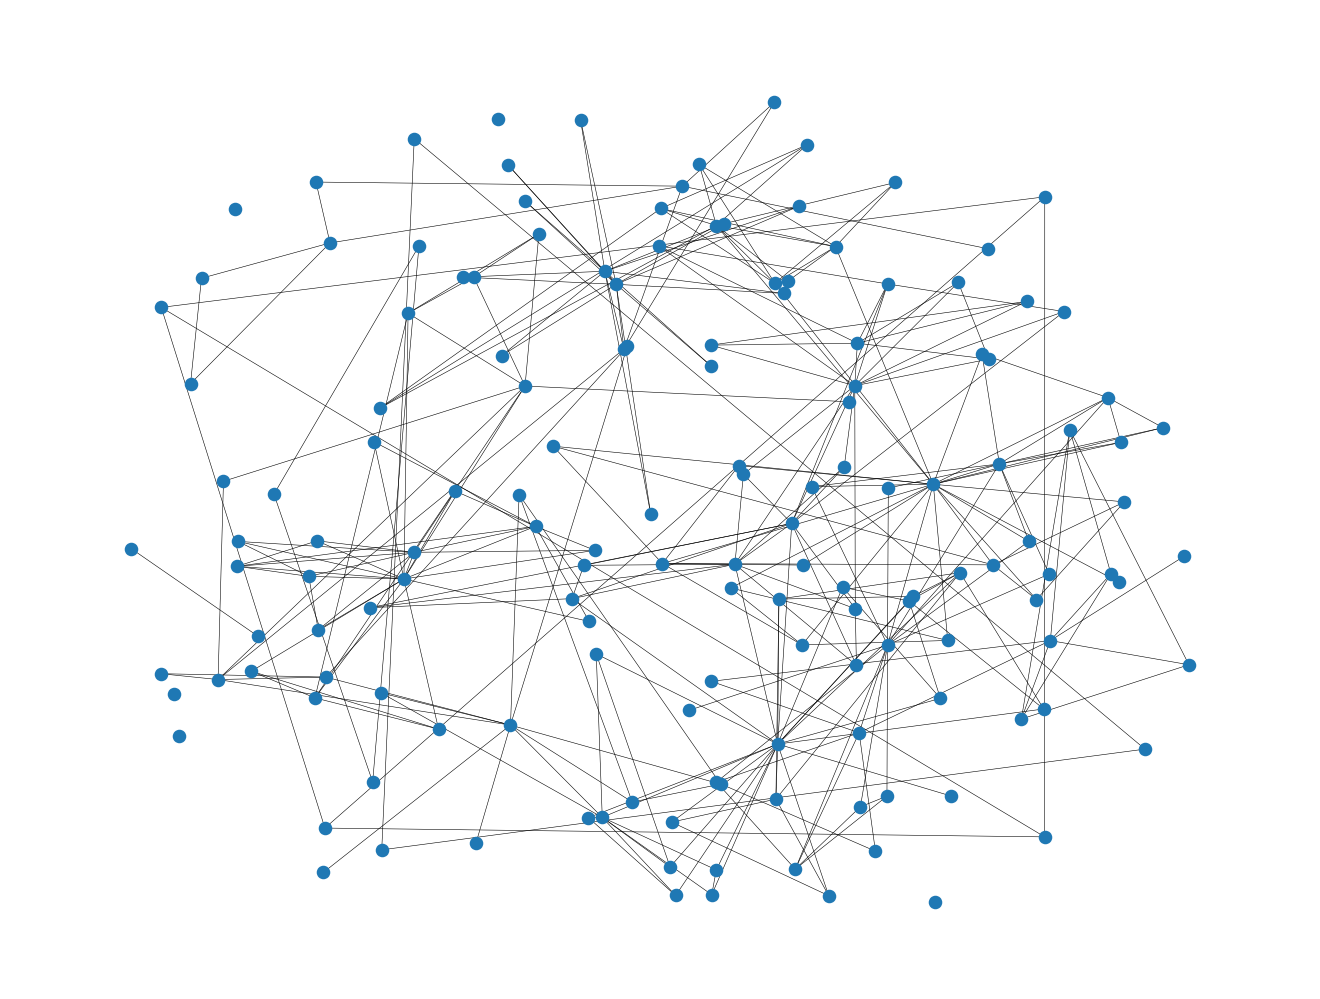

In [17]:
phraseLists = pickle.load(open(f"../Pickles/{identifier}_phrases.pkl", "rb"))
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [5]:
phraseEntropies = [(phrase.id, phrase.entropy + 1) for part in phraseLists for phrase in part]
bqm = dimod.generators.maximum_weight_independent_set(G.edges, phraseEntropies, strength_multiplier=2)
print(bqm)

BinaryQuadraticModel({'Violin I_1': -3.7024549619059113, 'Violin II_1': -3.976216224524763, 'Viola_1': -3.5, 'Cello_1': -3.5418848434970744, 'Cello_2': -1.0, 'Violin I_2': -1.0, 'Violin I_3': -3.7736843762620236, 'Violin II_3': -4.576911051568265, 'Viola_3': -3.5, 'Viola_4': -1.0, 'Cello_3': -3.377443751081734, 'Cello_4': -1.0, 'Violin I_4': -1.0, 'Violin I_5': -4.353240480262612, 'Violin II_4': -2.0, 'Violin II_5': -1.0, 'Violin II_6': -1.9182958340544896, 'Violin II_7': -1.0, 'Violin II_8': -3.7527152789797045, 'Violin II_9': -1.0, 'Violin II_10': -4.146852406035913, 'Viola_5': -4.029423942181381, 'Viola_6': -1.0, 'Viola_7': -4.267462841284266, 'Viola_8': -1.0, 'Viola_9': -2.4366664819166877, 'Cello_7': -2.0, 'Cello_8': -1.0, 'Cello_9': -3.892878689342031, 'Cello_10': -3.0, 'Cello_11': -1.0, 'Cello_12': -1.0, 'Cello_13': -3.5, 'Cello_14': -1.0, 'Cello_15': -1.9940302114769564, 'Violin I_6': -1.0, 'Violin I_7': -2.918295834054489, 'Violin I_8': -1.0, 'Violin I_9': -4.8689641616684, 'V

In [18]:
# Create colouring problem BQM

bqm = BinaryQuadraticModel(vartype="BINARY")

colours = {0:"red", 1:"green", 2:"blue"}
allPhrases = [phrase for part in phraseLists for phrase in part]

# Add all vertices for each colour
for i in colours:
    bqm.add_variables_from([(f"{phrase.id}_{i}", 0) for phrase in allPhrases])


for phrase in allPhrases:
    # Each vertex coloured at most once
    bqm.add_linear_inequality_constraint([(f"{phrase.id}_{i}",1) for i in colours], ub=1, lagrange_multiplier=1, label="One colour per vertex")
    # Maximise vertex weighting
    bqm.add_linear_from([(f"{phrase.id}_{i}", -phrase.entropy) for i in colours])

for u, v, d in G.edges.data():
    # Adjacent vertices have different colours
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{i}", 1) for i in colours])
    # Maximise edge weighting
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{j}", -d["weight"]) for i,j in iter.product(colours, repeat=2)])


print(bqm)

BinaryQuadraticModel({'Violin I_1_0': -3.7024549619059113, 'Violin I_2_0': -1.0, 'Violin I_3_0': -3.7736843762620236, 'Violin I_4_0': -1.0, 'Violin I_5_0': -4.353240480262612, 'Violin I_6_0': -1.0, 'Violin I_7_0': -2.918295834054489, 'Violin I_8_0': -1.0, 'Violin I_9_0': -4.8689641616684, 'Violin I_10_0': -1.0, 'Violin I_11_0': -3.4340437717594363, 'Violin I_12_0': -1.0, 'Violin I_13_0': -3.4340437717594363, 'Violin I_14_0': -1.0, 'Violin I_15_0': -2.0, 'Violin I_16_0': -1.0, 'Violin I_17_0': -2.0, 'Violin I_18_0': -1.0, 'Violin I_19_0': -1.7219280948873623, 'Violin I_20_0': -1.0, 'Violin I_21_0': -3.364011629520427, 'Violin I_22_0': -1.0, 'Violin I_23_0': -1.9709505944546686, 'Violin I_24_0': -1.0, 'Violin I_25_0': -4.145247327790328, 'Violin I_26_0': -2.584962500721156, 'Violin I_27_0': -2.0, 'Violin I_28_0': -1.0, 'Violin I_29_0': -3.7024549619059113, 'Violin I_30_0': -1.0, 'Violin I_31_0': -3.935440200948998, 'Violin I_32_0': -1.0, 'Violin I_33_0': -1.9182958340544896, 'Violin I_34

In [19]:
# Solve classically

dfClassical = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

In [38]:
import re

# Show results
colours = {0:"red", 1:"green", 2:"blue"}
def processNode(node):
    groups = re.match(r"(.*_\d+)_(\d+)", node).groups()
    return (groups[0], colours[int(groups[1])])

                                              sample       energy  \
0  {'Cello_10_0': 1, 'Cello_10_1': 1, 'Cello_10_2... -3936.927902   
1  {'Cello_10_0': 1, 'Cello_10_1': 1, 'Cello_10_2... -3936.927902   
2  {'Cello_10_0': 1, 'Cello_10_1': 1, 'Cello_10_2... -3936.927902   
3  {'Cello_10_0': 1, 'Cello_10_1': 1, 'Cello_10_2... -3936.927902   
4  {'Cello_10_0': 1, 'Cello_10_1': 1, 'Cello_10_2... -3936.927902   

   num_occurrences  num_steps  
0                1        197  
1                1        225  
2                1        219  
3                1        209  
4                1        208  
['Cello_10', 'Cello_10', 'Cello_10', 'Cello_11', 'Cello_11', 'Cello_11', 'Cello_12', 'Cello_12', 'Cello_12', 'Cello_13', 'Cello_13', 'Cello_13', 'Cello_14', 'Cello_14', 'Cello_14', 'Cello_15', 'Cello_15', 'Cello_15', 'Cello_16', 'Cello_16', 'Cello_16', 'Cello_17', 'Cello_18', 'Cello_18', 'Cello_18', 'Cello_19', 'Cello_1', 'Cello_1', 'Cello_20', 'Cello_20', 'Cello_20', 'Cello_21', 'Cello_21'

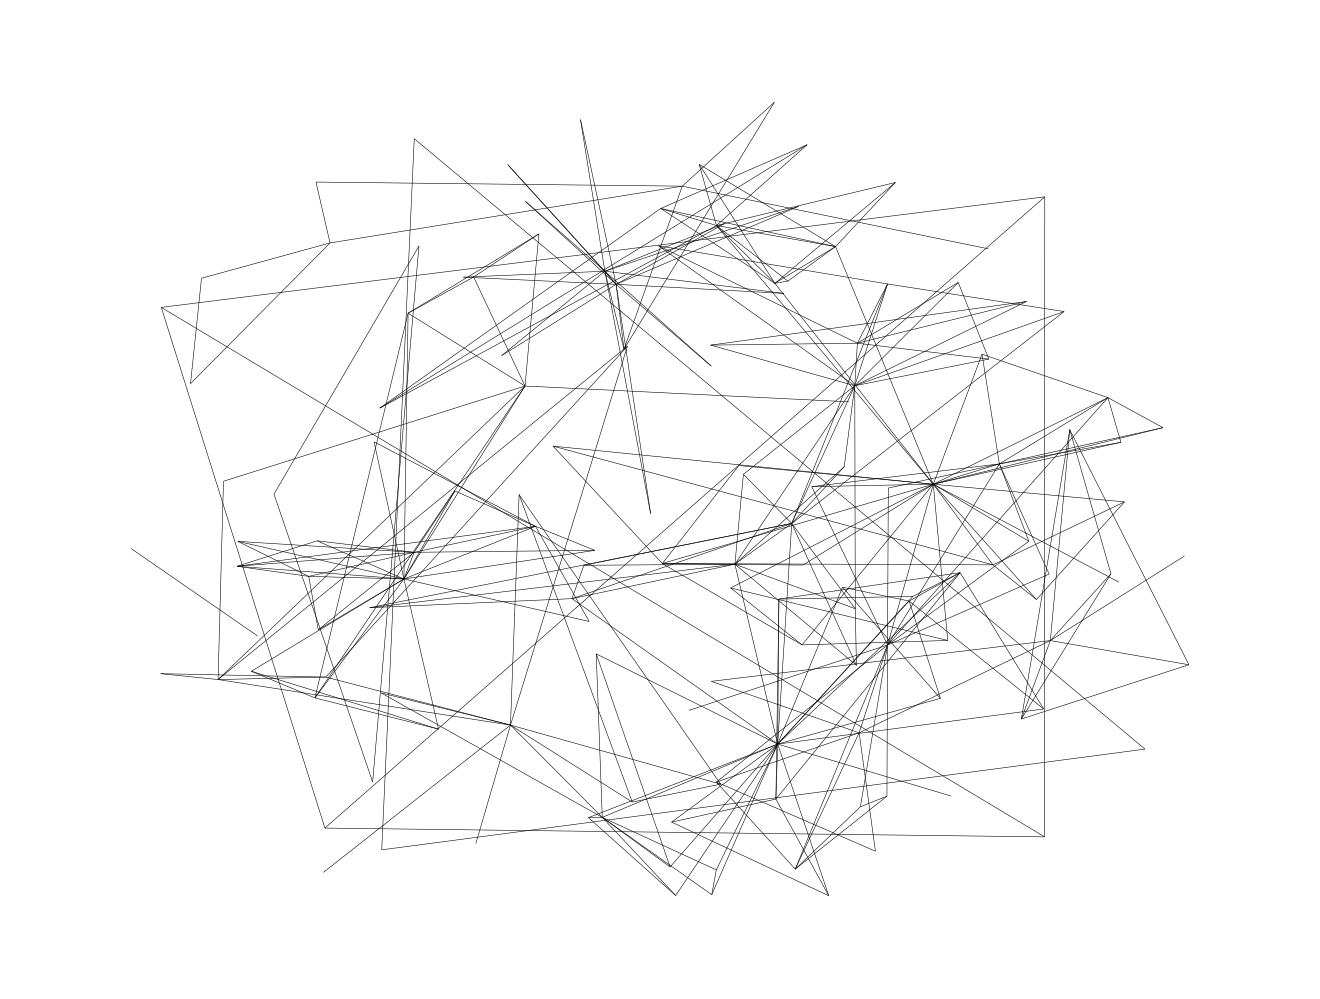

In [40]:
import re

print(dfClassical.head())
#print(df["energy"].sort_values(ascending=True))

sample = dfClassical["sample"][0]
chosen = [processNode(x)[0] for x in sample if sample[x] == 1]
print(chosen)

nx.draw(G, pos, node_size=15, width=0.2, nodelist=[])
#nx.draw_networkx_nodes(G, pos, nodelist=chosen, node_color=[processNode(n)[1] for n in chosen], node_size=15)

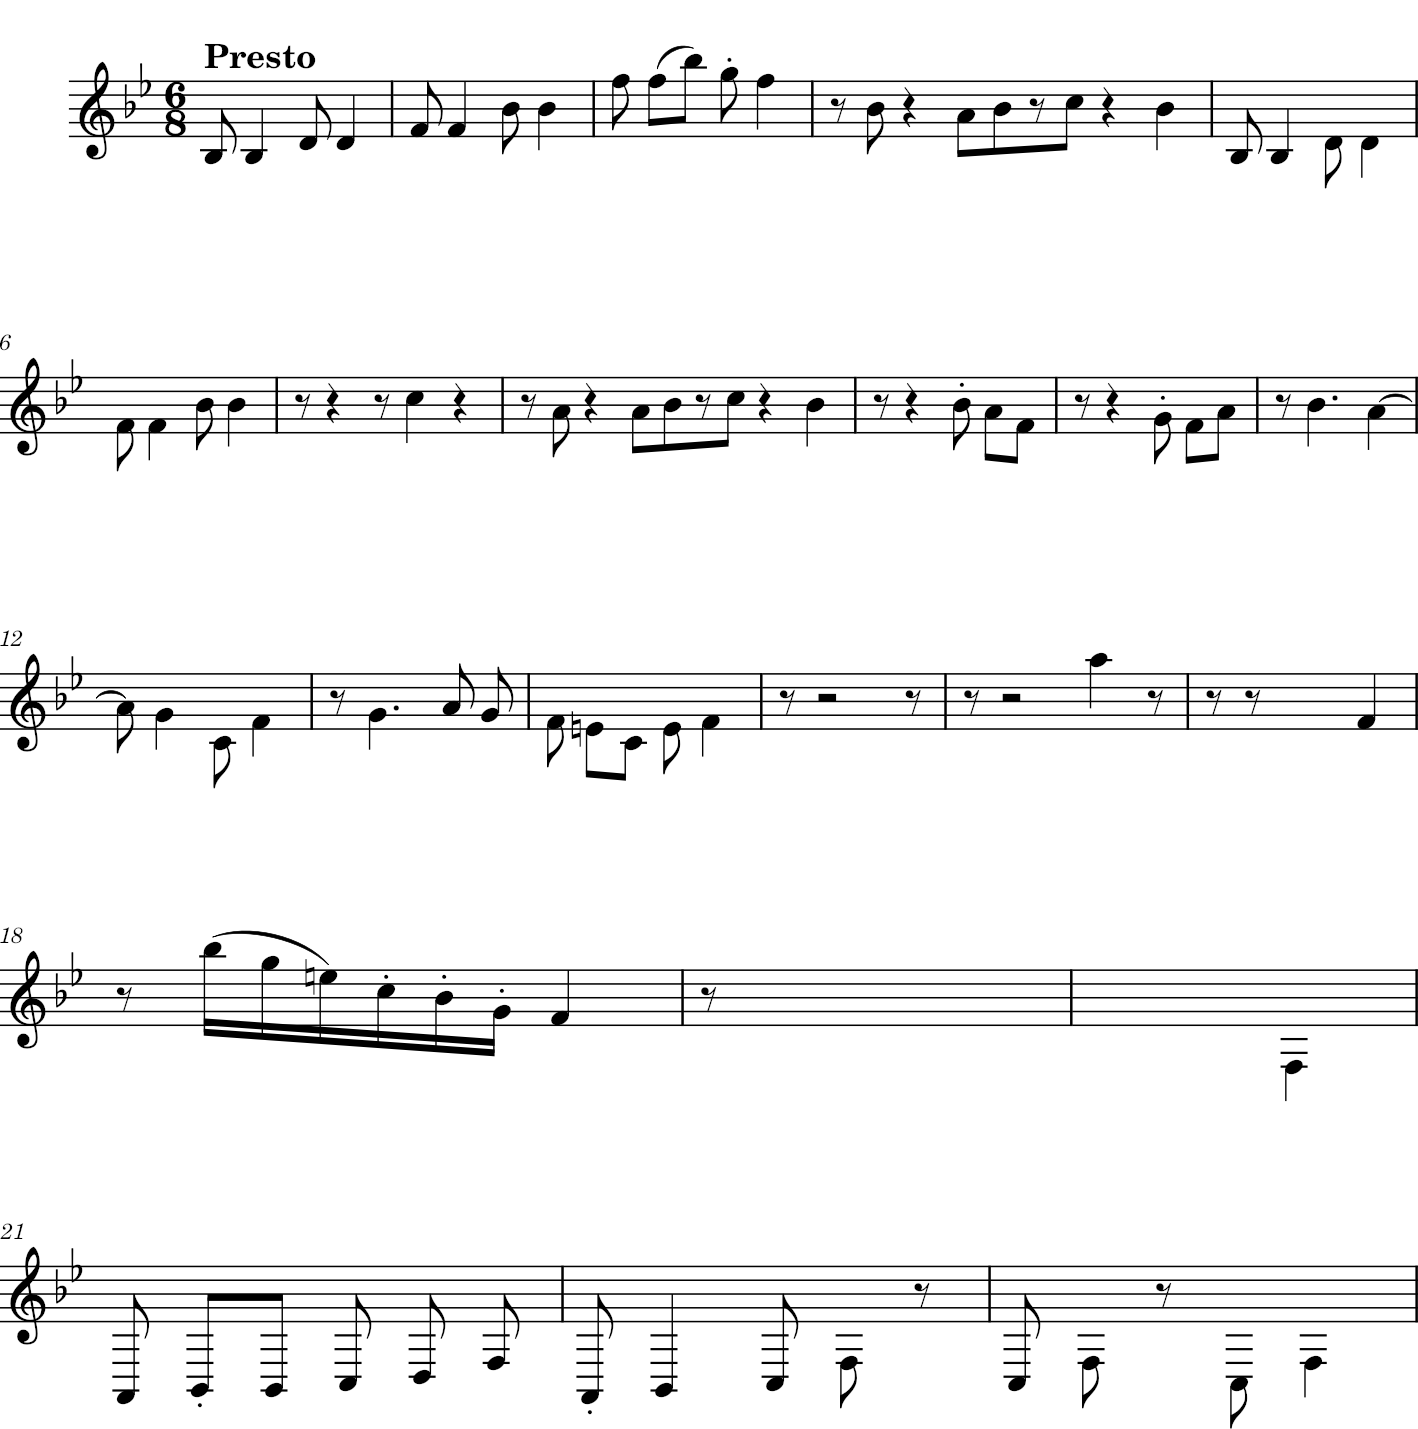

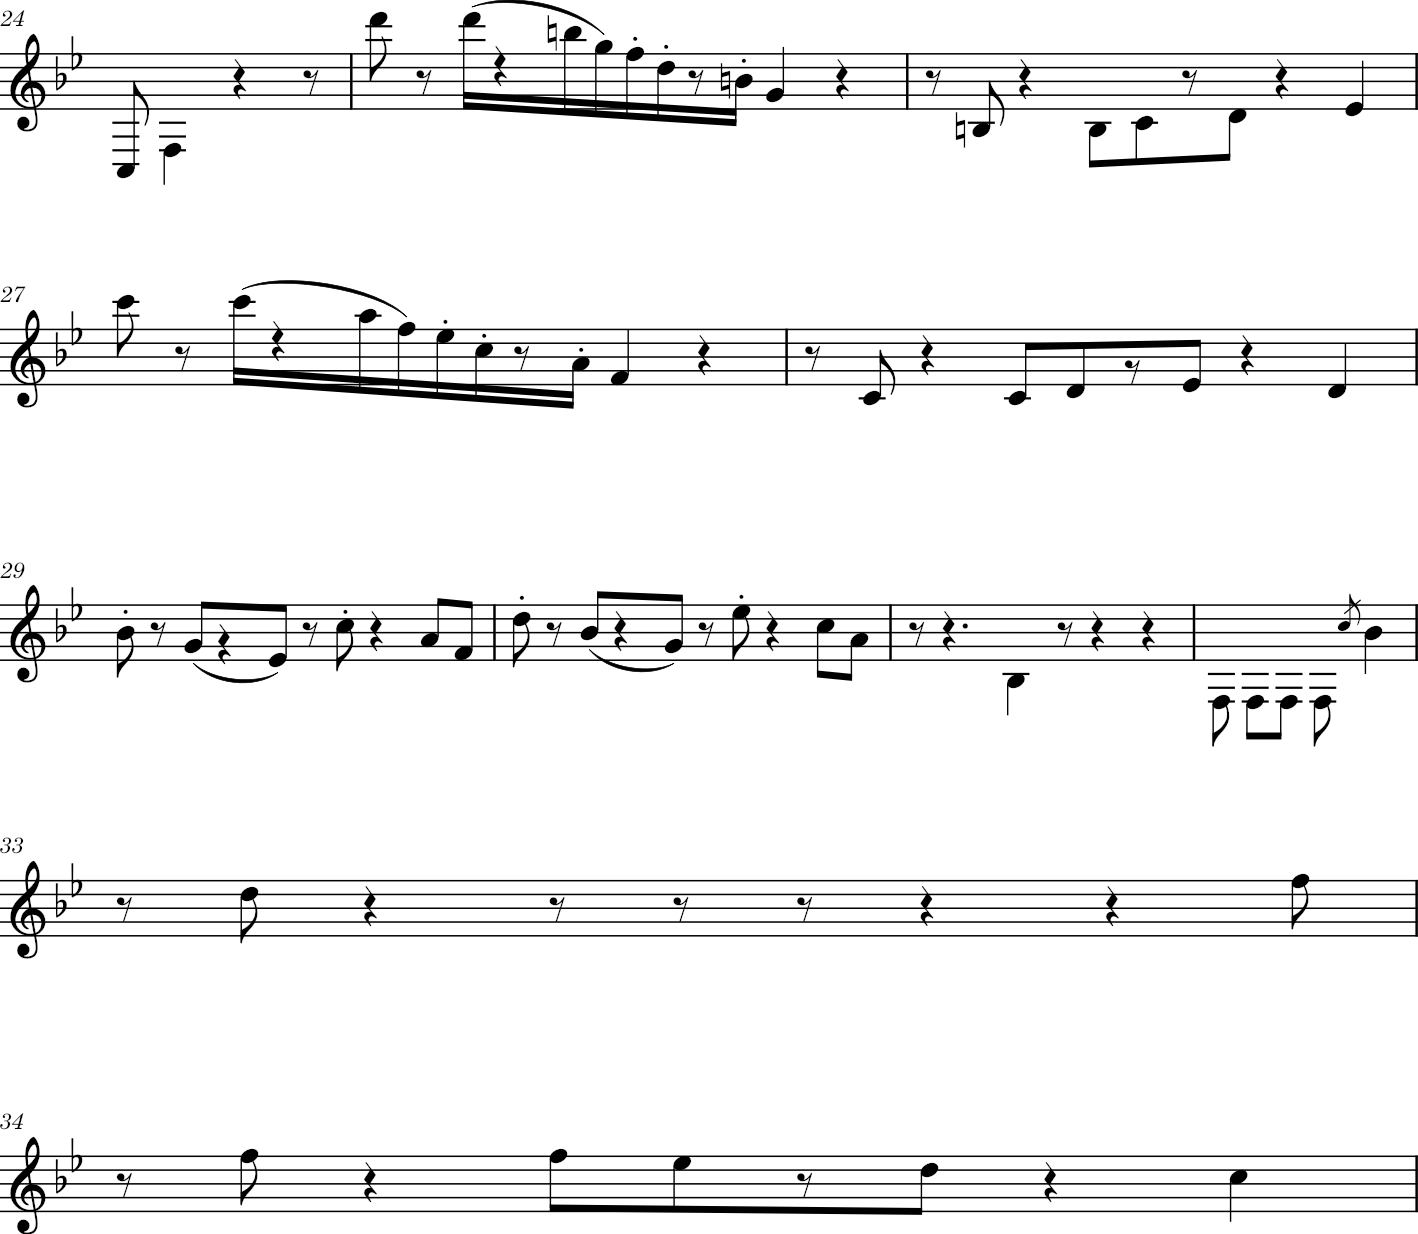

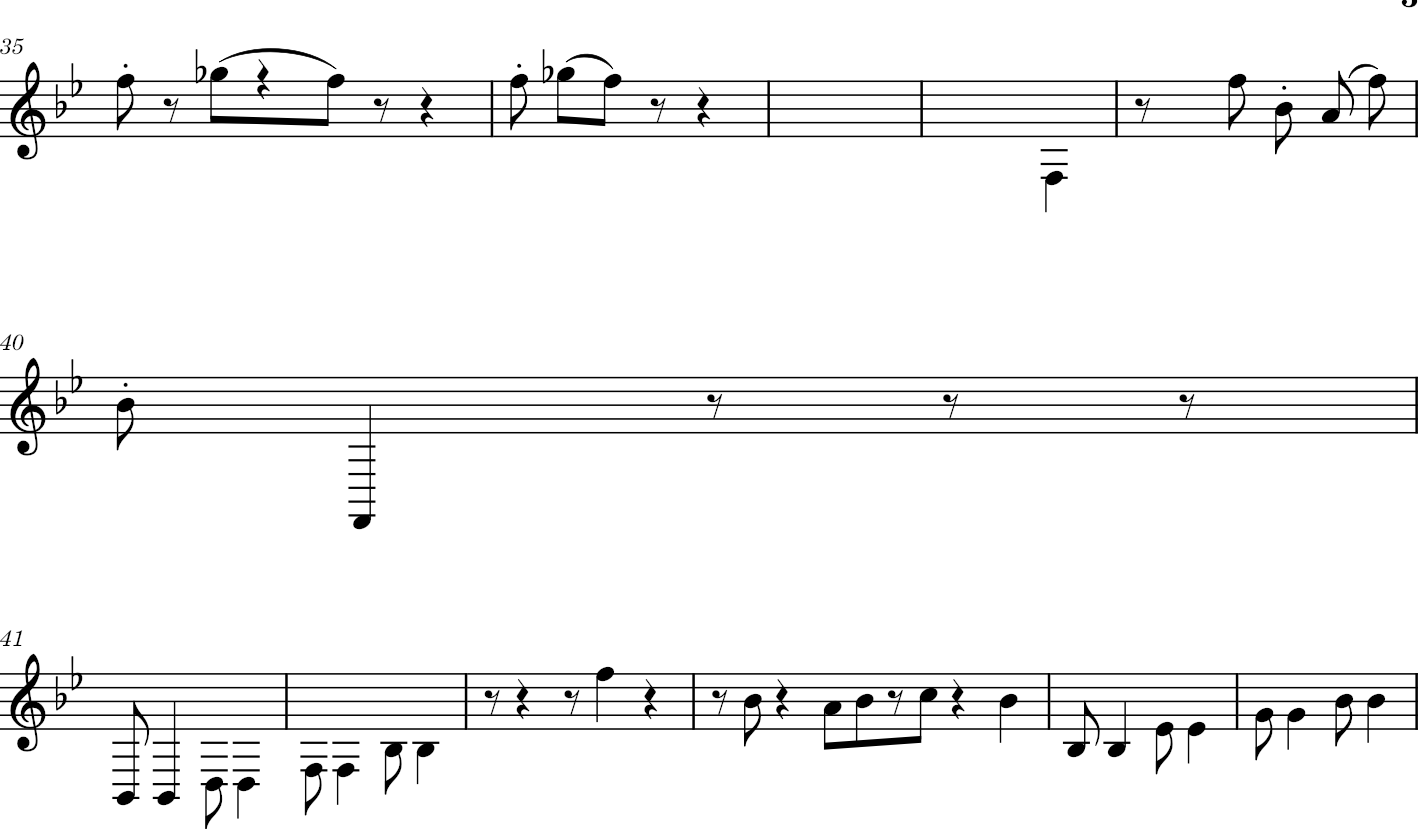

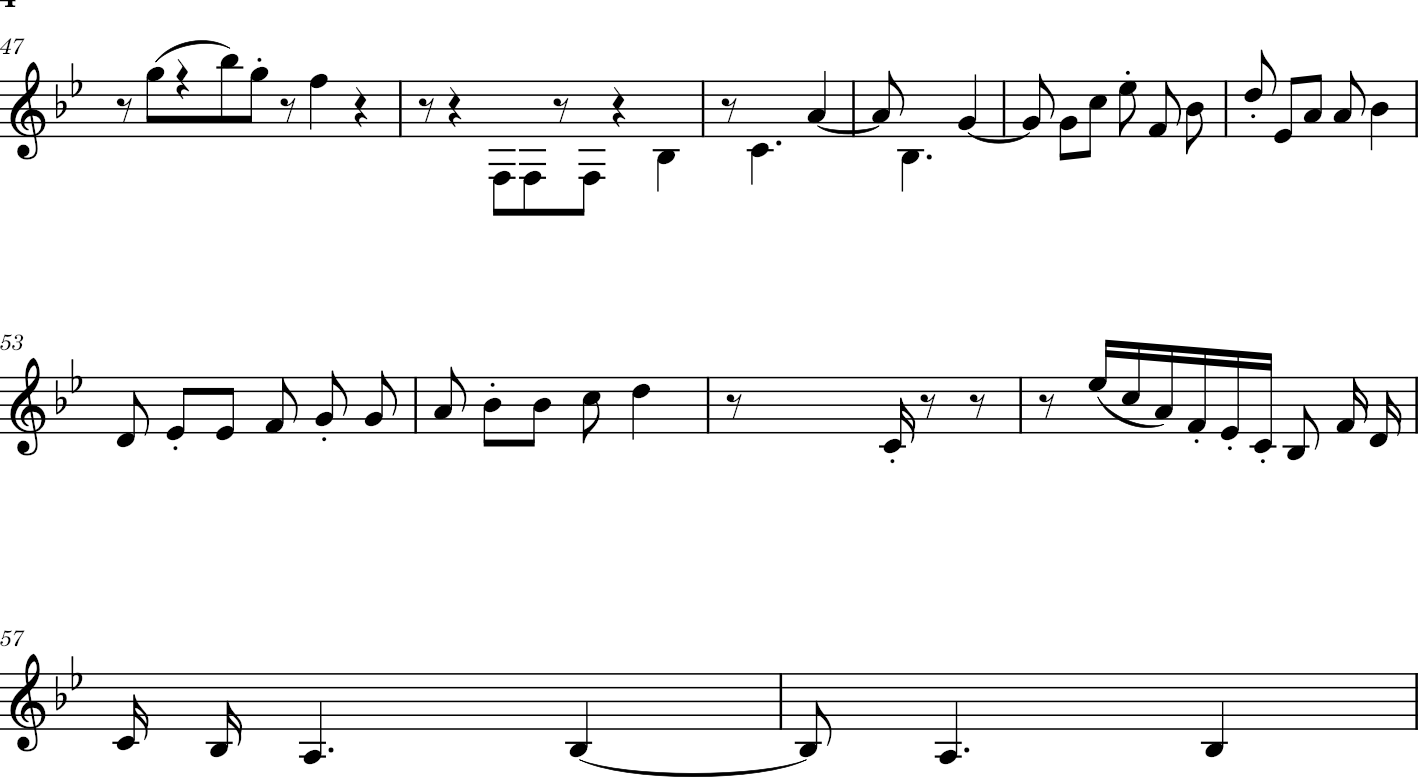

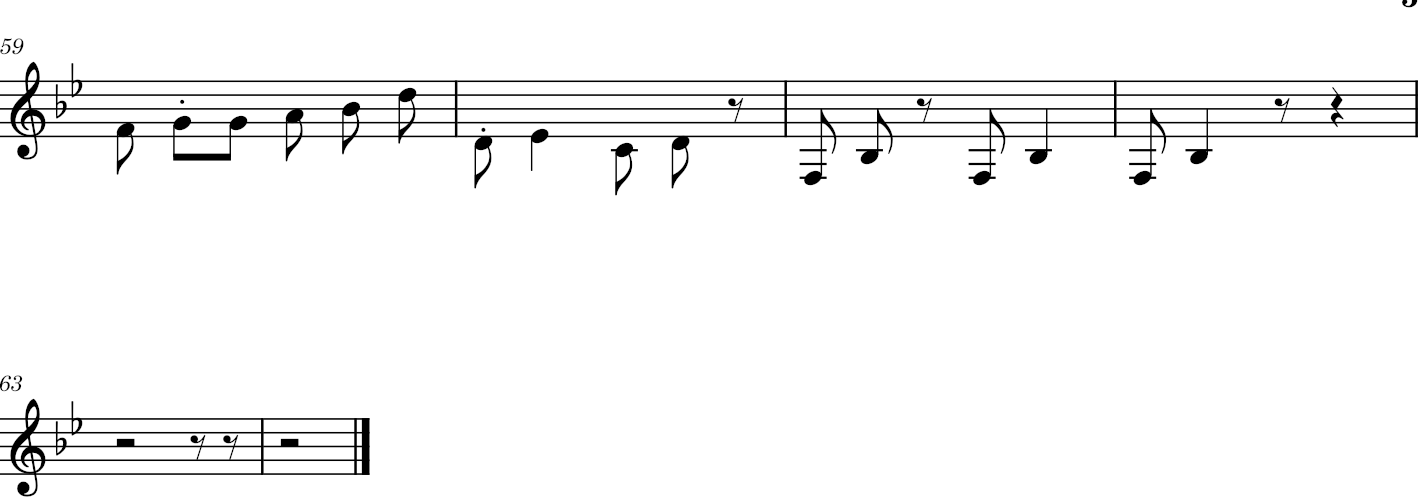

In [32]:
# Final arrangement

arrangement = stream.Stream()

for phrase in [phrase for part in phraseLists for phrase in part]:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

excerpt.show("midi")
arrangement.show("midi")
arrangement.show()

In [38]:
# Save data

excerpt.write("xml", f"../Pickles/{identifier}_excerpt.xml")
pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))
pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))